# **ProgettoCV Training - Studenti: Daniele Francesca, Leto Marco**

In [45]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
from copy import copy
import math
import multiprocessing
import os
from pathlib import Path
import random
import PIL.Image as PIL
from typing import Any, Dict, Optional
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask
import matplotlib.patches as patches
from PIL import Image
import cv2
from torchvision.utils import save_image

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [2]:
train_dir = "Dataset/trainingset"
test_dir="Dataset/testset"

# Carica il file JSON di addestramento
train_json_path = os.path.join(train_dir, "train.json")
coco_train = COCO(train_json_path)
test_json_path = os.path.join(test_dir, "test.json")
coco_test = COCO(test_json_path)

# disponibilità e utilizzo della GPU
torch.cuda.is_available()
device = get_torch_device()
dtype = torch.float32
device, dtype

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


('cpu', torch.float32)

### **1. Esplorazione e Analisi dei dati**

Categories : 
{'supercategory': 'cable', 'id': 0, 'name': 'cable'}
{'supercategory': 'tower_lattice', 'id': 1, 'name': 'tower_lattice'}
{'supercategory': 'tower_tucohy', 'id': 2, 'name': 'tower_tucohy'}
{'supercategory': 'tower_wooden', 'id': 3, 'name': 'tower_wooden'}
Image Dims: (700, 700)


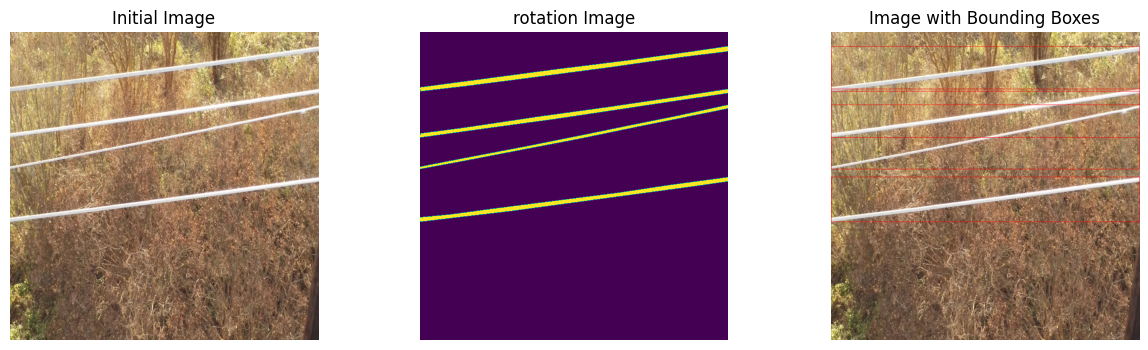

Image Dims: (700, 700)


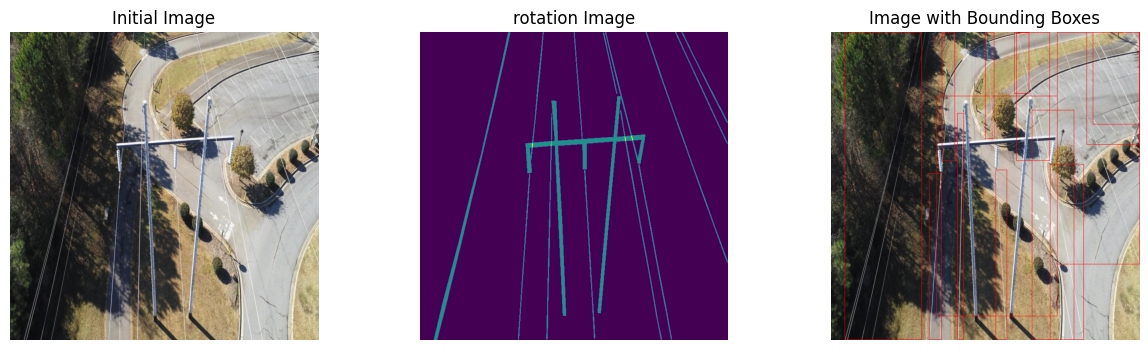

In [3]:
# Visualizza informazioni sulle categorie
categories = coco_train.loadCats(coco_train.getCatIds())
print("Categories : ")
for category in categories:
    print(category)

# Visualizzazione delle informazioni sulle immagini
train_img_ids = coco_train.getImgIds()
num_samples_to_display = 2


for i in range(num_samples_to_display):
    image_info = coco_train.loadImgs(train_img_ids[i])[0]
    img_path = os.path.join(train_dir, image_info["file_name"])
    img = Image.open(img_path)
    image1=np.array(Image.open(img_path).convert('RGB'))

    # Print the dimensions of the image
    print(f"Image Dims: {img.size}")

    # Carica maschere
    annotation_ids = coco_train.getAnnIds(imgIds=image_info['id'])
    annotations = coco_train.loadAnns(annotation_ids)

    mask = 0
    for ann in annotations:
        mask += coco_train.annToMask(ann)

        # Draw the bounding box
        bbox = ann['bbox']
        bbox = [int(coord) for coord in bbox]

        #Disegna il bbox sull'immagine prelevata
        cv2.rectangle(image1, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (255,0,0), 1)


    # Immagine originale
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Initial Image')

    ax[1].imshow(mask)
    ax[1].axis('off')
    ax[1].set_title('rotation Image')

    ax[2].imshow(image1)
    ax[2].axis('off')
    ax[2].set_title('Image with Bounding Boxes')

    plt.show()




In [4]:
# Recupero dei percorsi dei file delle immagini per i set
img_file_paths = get_img_files(train_dir)
img_file_test_paths = get_img_files(test_dir)

pd.DataFrame({"Image File": [file.name for file in img_file_paths]}).head()

,Image File
0,04_585.jpg
1,06_5355.jpg
2,07_1035.jpg
3,07_1875.jpg
4,08_1830.jpg


Visualizziamo la distribuzione delle istanze nelle diverse categorie:

Conteggio delle istanze per categoria:

Categoria 0: 6775 istanze
Categoria 1: 276 istanze
Categoria 2: 152 istanze
Categoria 3: 222 istanze


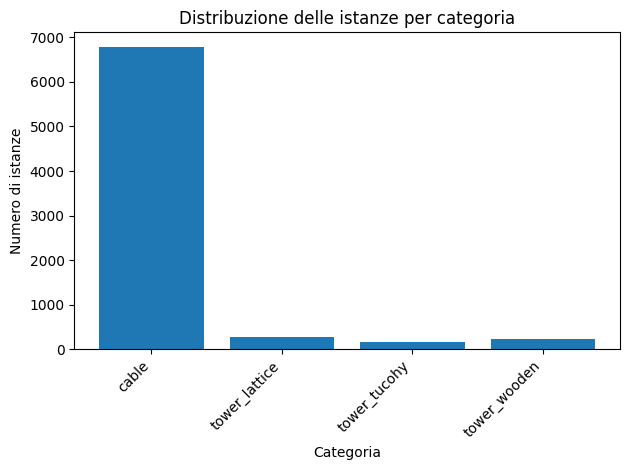

In [5]:
# Visualizzazione del conteggio delle istanze per categoria
category_instance_counts = {category['id']: 0 for category in categories}

for annotation_id in coco_train.getAnnIds():
    annotation = coco_train.loadAnns(annotation_id)[0]
    category_id = annotation['category_id']
    category_instance_counts[category_id] += 1

print("Conteggio delle istanze per categoria:\n")
for category_id, count in category_instance_counts.items():
    print(f"Categoria {category_id}: {count} istanze")

# Estrai le informazioni per il grafico
category_names = [category['name'] for category in categories]
category_counts = list(category_instance_counts.values())

plt.bar(category_names, category_counts)
plt.xlabel('Categoria')
plt.ylabel('Numero di istanze')
plt.title('Distribuzione delle istanze per categoria')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

La Mask RCNN codifica lo sfondo con id=0, per questo motivo è necessario introdurre la categoria "background", in modo da non avere ambiguità nella predizione delle classi.

In [6]:
#Si aggiunge la classe di background
category_names =['background']+[category['name'] for category in categories]
pd.DataFrame(category_names)

,0
0,background
1,cable
2,tower_lattice
3,tower_tucohy
4,tower_wooden


### **2. Aumento del Dataset**

Si parte da delle immagini in risoluzione (5472 x 3078) proveniente da rilievi con droni, per questo motivo è necessario definire una funzione crop and resize che divide l'immagine originale in 6 blocchi (1500 x 1500) che vengono poi ridimensionati col formato del dataset (700 x 700)

In [10]:

def CropAndResize(dim, imgDirectory):
    counter=1
    img_file_paths = get_img_files(imgDirectory)

    for el in img_file_paths:
        immagine = PIL.open(el)
        larghezza,altezza= immagine.size

        dimBlocco=1400

        blocchi_orizzontali = larghezza // dimBlocco
        blocchi_verticali = altezza // dimBlocco

        for i in range(blocchi_orizzontali):
                for j in range(blocchi_verticali):
                    # Calcola le coordinate del blocco corrente
                    x = i * dimBlocco
                    y = j * dimBlocco

                    # Estrai il blocco corrente
                    blocco = immagine.crop((x, y, x + dimBlocco, y + dimBlocco))
                    blocco = blocco.resize((dim, dim))


                    # Salva il blocco in un nuovo file
                    nome_file = f"blocco_{i}_{j}_img{counter}.jpg"
                    percorso_completo = f"{imgDirectory}Splitted/{nome_file}"
                    blocco.save(percorso_completo)
                    counter+=1

#Il metodo è chiamato sulla cartella "FotoDrone"
CropAndResize(700,'Esempio')


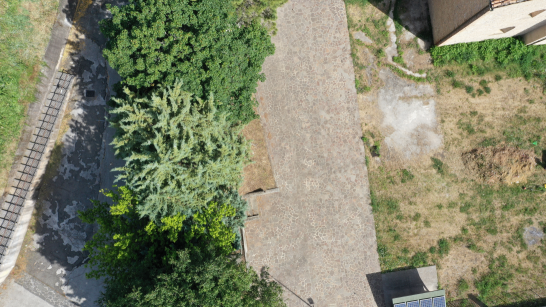

(-0.5, 699.5, 699.5, -0.5)

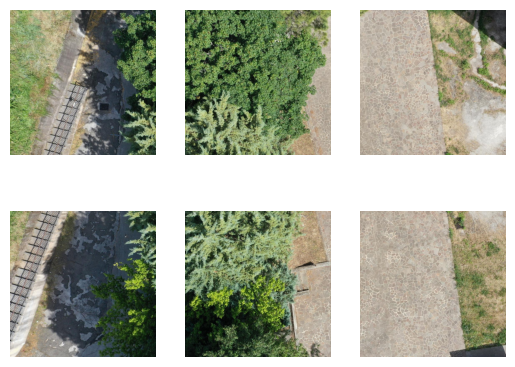

In [24]:
fix , ax = plt.subplots(2,3)

ax[0,0].imshow(PIL.open('EsempioSplitted/blocco_0_0_img1.jpg'))
ax[0,0].axis('off')

ax[1,0].imshow(PIL.open('EsempioSplitted/blocco_0_1_img2.jpg'))
ax[1,0].axis('off')

ax[0,1].imshow(PIL.open('EsempioSplitted/blocco_1_0_img3.jpg'))
ax[0,1].axis('off')

ax[1,1].imshow(PIL.open('EsempioSplitted/blocco_1_1_img4.jpg'))
ax[1,1].axis('off')

ax[0,2].imshow(PIL.open('EsempioSplitted/blocco_2_0_img5.jpg'))
ax[0,2].axis('off')

ax[1,2].imshow(PIL.open('EsempioSplitted/blocco_2_1_img6.jpg'))
ax[1,2].axis('off')

Si aggiungono alle immagini ottenute i cavi, utilizzando la seguente successione di passi:
1. Si prende un'immagine da moficiare
2. Si seleziona casualmente da un'insieme di immagini del training set selezionate e memorizzate nella cartella "MaschereCavi", l'immagine da cui ottenere le maschere
3. Si genera un vettore di booleani pari al numero di maschere dell'immagine del training, in cui almeno la meta degli elementi sono True. L'elemento in posizione i, se True, indica che la maschera corrispondente sarà trasferita sulla nuova immagine
4. Data una nuova immagine modificata, ne vengono salvate le specifiche, maschere e bbox, in appositi array che serviranno a realizzare il json dei nuovi dati con formato COCO

In [ ]:
#Si realizza un dizionario che associa al file name, l'id dell'immagini, per ogni elemento nel training set
dictFileId={}
with open('Dataset/trainingset/train.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    dati_json = json.load(file_json)

for image in dati_json['images']:
    dictFileId[image['file_name']]=image['id']

#Si creno i vettori per memorizzare le annotation
images=[]
idImages=0

newAnnotations=[]
idAnnotations=0

#Si crea un dizionario che associa ad un indice il nome di un'immagine:
img_path = get_img_files('CreazioneImmagini/Img2')
img_dict = {index: path for index, path in enumerate(img_path)}

#Si crea un dizionario che associa ad un indice il nome di un'immagine:
img_line_path = get_img_files('CreazioneImmagini/MaschereCavi')
img_line_dict = {index: path for index, path in enumerate(img_line_path)}

transform = transforms.Compose([
    transforms.ToTensor(),
])


for i in range(len(img_dict)):
    immagine=PIL.open(img_dict[i])
    immagine=transform(immagine)

    nome_file=str(img_dict[i]).split('\\')[2]

    #Si aggiungono le informazioni dell nuova immagini al vettore
    imageInfo={
            "height": 700,
            "width": 700,
            "id": idImages,
            "file_name": nome_file
        }
    
    images.append(imageInfo)
    
    #Si sceglie l'immagine da cui scegliere le annotation
    pathImg=img_line_dict[random.randint(0,len(img_line_dict)-1)]
    cableImg=PIL.open(pathImg)
    cableImg=transform(cableImg)

    nome_file_ann=str(pathImg).split('\\')[2]
    print(nome_file_ann)

    id=dictFileId[nome_file_ann]

    img_info = coco_train.loadImgs(id)[0]
    ann_ids = coco_train.getAnnIds(imgIds=img_info['id'])
    annotations = coco_train.loadAnns(ann_ids)

    #Si selezionano casualmente i cavi da aggiungere
    if(len(annotations)==1):
        cVector=[True]
    else:
        cVector= [random.choice([True, False]) for _ in range(len(annotations))]
        while(cVector.count(True)==len(cVector)/2):
            cVector[random.randint(0,len(cVector)-1)]=True

    index=-1
    for ann in annotations:
        index+=1
        if(cVector[index]==True):
            newMask=zero_matrix = np.zeros((700, 700))
            mask=coco_train.annToMask(ann)
            #Si itera sulla maschera:
            for i in range(len(mask)):
                for j in range(len(mask[0])):
                    if(mask[i][j]==1):
                        newMask[i][j]=1
                        #Si modifica il valore dei pixel sui 3 canali (RGB)
                        immagine[0][i][j]=cableImg[0][i][j]
                        immagine[1][i][j]=cableImg[1][i][j]
                        immagine[2][i][j]=cableImg[2][i][j]

            #Si aggiungono le informazioni della annotation appena aggiunta sull'immagine
            imageAnn={
                "segmentation": ann['segmentation'],
                "iscrowd": 0,
                "area": ann['area'],
                "image_id": idImages,
                "bbox": ann['bbox'],
                "category_id": ann['category_id'],
                "id": idAnnotations
            }
            newAnnotations.append(imageAnn)
            idAnnotations+=1
    
    # Salva l'immagine
    save_image(immagine,f'CreazioneImmagini/Img2Cavi/{nome_file}_{idImages}.jpg')

    idImages+=1

categories=[{
            "supercategory": "cable",
            "id": 0,
            "name": "cable"
        },
        {
            "supercategory": "tower_lattice",
            "id": 1,
            "name": "tower_lattice"
        },
        {
            "supercategory": "tower_tucohy",
            "id": 2,
            "name": "tower_tucohy"
        },
        {
            "supercategory": "tower_wooden",
            "id": 3,
            "name": "tower_wooden"
        }]

#Si crea il nuovo json in formato COCO
newJson={
    "images":images,
    "categories":categories,
    "annotations":newAnnotations
}

#Si scrive su file il dizionario
with open('CreazioneImmagini/Img2Cavi/Img2Cavi.json', "w") as file_json:
    # Scrivi i dati nel file JSON
    json.dump(newJson, file_json)




Le immagini appena create vengono poi selezionate, per poi unire i due json

In [ ]:
image_id=#Current train.json last image_id
annotation_id=#Current train.json last annotation_id


images=[]
newAnnotations=[]

#Si prende il nome dei file rimasti dopo la selezione
img_path = get_img_files('CreazioneImmagini/Img1Cavi')
vettoreFile=[]
for i in range(len(img_path)):
    vettoreFile.append(str(img_path[i]).split('\\')[2])

#Si aprono i due json:
with open('CreazioneImmagini/Dataset/trainingset/train.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    train_json = json.load(file_json)

with open('CreazioneImmagini/Img2Torri/Img2TorriNew.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    cable_json = json.load(file_json)

#Si aggiungono le immagini e si crea un dizionario che mappa il vecchioId con il nuovo Id
dictOldIdNewId={}
oldId=[]
for image in cable_json['images']:
    if(image['file_name'] in vettoreFile):    
        imageInfo={
                "height": 700,
                "width": 700,
                "id": image_id,
                "file_name": image['file_name']
            }
        oldId.append(image['id'])
        dictOldIdNewId[image['id']]=image_id
        images.append(imageInfo)
        image_id+=1


#Si creano le nuove annotation
for annotazioni in cable_json['annotations']:
    if(annotazioni['image_id'] in oldId):
        imageAnn={
            "segmentation": annotazioni['segmentation'],
            "iscrowd": 0,
            "area": annotazioni['area'],
            "image_id": dictOldIdNewId[annotazioni['image_id']],
            "bbox": annotazioni['bbox'],
            "category_id": annotazioni['category_id'],
            "id": annotation_id
            }
        annotation_id+=1
        newAnnotations.append(imageAnn)

newJson={
    "images":train_json['images'] + images,
    "categories":train_json['categories'],
    "annotations":train_json['annotations'] + newAnnotations
}

with open('train.json', "w") as file_json:
    # Scrivi i dati nel file JSON
    json.dump(newJson, file_json)

Si aggiungono alle immagini ottenute le torri e i relativi cavi, utilizzando la seguente successione di passi:
1. Per semplicita si scelgono immagini del training set che contengono torri la quale i cavi si spostano lungo la direzione orizzontale o verticale dell'immagine. Queste vengono poi memorizzate in due cartelle differenti
2. Si prende un'immagine da modificare tra quelle precedentemente prodotte
3. Si seleziona casualmente un'immagine contenuta nella cartella "MaschereTorri" (orizzontale o verticale che sia)
4. Se l'immagine selezionata è etichettata come "Orizzontale" si genera un numero intero compreso tra 0 ed (1/3 * altezza torre) per definire lo shifting che si vuole applicare alle maschere. Infatti per evitare di costruire immagini che risultano identiche a quelle del training set, si applica uno spostamento alle maschere. Allo stesso modo se l'immagine è etichettata come "Verticale", in cui lo shifting è definito come un intero compreso tra 0 ed (1/3 * larghezza torre) e si introduce una direzione (1,-1) per spostare le maschere a destra o a sinistra rispetto alla posizione iniziale
5. Una volta creata la nuova maschera, si aggiungono, se ancora parte dell'immagine, i cavi associati
6. Data una nuova immagine modificata, ne vengono salvate le specifiche, maschere e bbox, in appositi array che serviranno a realizzare il json dei nuovi dati con formato COCO

Si noti che rispetto all'aggiunta dei cavi, in questo caso non è possibile copiare direttamente l'annotazione COCO della maschera appena copiata, di conseguenza una volta ottenuta la maschera viene utilizzato il metodo get_segmentation, per ottenere i vertici del poligono ed il comando  cv2.boundingRect per ottenere le coordinate del bbox associato

In [25]:
#Si definiscono i metodi di supporto
def copyAndZero(maschera):
    ret=np.copy(maschera)
    for i in range(len(ret)):
        for j in range(len(ret)):
            ret[i][j]=0
    return ret

def get_segmentation(mask):

    contours, _= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    for contour in contours:
        # Valid polygons have >= 6 coordinates (3 points)
        if contour.size >= 6:
            segmentation.append(contour.flatten().tolist())

    return segmentation

In [ ]:
#Si crea un dizionario che associa ad un indice il nome di un'immagine:
img_path = get_img_files('CreazioneImmagini/Img2N')
img_dict = {index: path for index, path in enumerate(img_path)}


#Si crea un dizionario che associa ad un indice il nome di un'immagine:
img_tower_path = get_img_files('CreazioneImmagini/MaschereTorri/Verticale')
img_tower_dict = {index: path for index, path in enumerate(img_tower_path)}

#Si crea un dizionario che associa ad un indice il nome di un'immagine:
img_tower_path2 = get_img_files('CreazioneImmagini/MaschereTorri/Orizzontale')
img_tower_dict2 = {index: path for index, path in enumerate(img_tower_path2)}

index=0
start=len(img_tower_dict)
for i in range(len(img_tower_dict2)):
    img_tower_dict[start+index]=img_tower_dict2[i]
    index+=1

coco_train = COCO("Dataset/trainingset/train.json")

transform = transforms.Compose([
    transforms.ToTensor(),
])

with open('Dataset/trainingset/train.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    dati_json = json.load(file_json)

idImages=0
idAnnotations=0
images=[]
newAnnotations=[]

for i in range(len(img_dict)):
    immagine=PIL.open(img_dict[i])
    immagine=transform(immagine)

    nome_file=str(img_dict[i]).split('\\')[2]

    imageInfo={
        "height": 700,
        "width": 700,
        "id": idImages,
        "file_name": str(idImages)+'T'+nome_file
    }
    images.append(imageInfo)

    pathImg=img_tower_dict[random.randint(0,len(img_tower_dict)-1)]
    towerImg=PIL.open(pathImg)
    towerImg=transform(towerImg)

    towerType=str(pathImg).split('\\')[2]

    nomeFile=str(pathImg).split('\\')[3]

    id=dictFileId[nomeFile]

    #Si caricano le anotation dell'immagine con id=id
    img_info = coco_train.loadImgs(id)[0]
    ann_ids = coco_train.getAnnIds(imgIds=img_info['id'])
    annotations = coco_train.loadAnns(ann_ids)

    #Si prende lo shift dell'immagine:

    shiftH=0
    shiftW=0
    direct=random.choice([-1,1])

    for ann in annotations:
        #Essendo le immagini con tutte una torre, sarà la torre
        if(ann['category_id']>0):
            shiftH=random.randint(0,int(ann['bbox'][3]/2))
            shiftW=random.randint(0,int(ann['bbox'][2]/2))

    

    for ann in annotations:
        if(towerType=='Orizzontale'):
            mask=coco_train.annToMask(ann)
            newMask=copyAndZero(mask)
            for i in range(len(mask)):
                for j in range(len(mask[0])):
                    if(mask[i][j]==1 and i+shiftH<700):
                        newMask[i+shiftH][j]=1  
                        immagine[0][i+shiftH][j]=towerImg[0][i][j]
                        immagine[1][i+shiftH][j]=towerImg[1][i][j]
                        immagine[2][i+shiftH][j]=towerImg[2][i][j]
        if(towerType=='Verticale'):
                mask=coco_train.annToMask(ann)     
                newMask=copyAndZero(mask)
                for i in range(len(mask)):
                    for j in range(len(mask[0])):
                        if(mask[i][j]==1 and j+direct*shiftW<700 and j+direct*shiftW>0):
                            newMask[i][j+direct*shiftW]=1
                            immagine[0][i][j+direct*shiftW]=towerImg[0][i][j]
                            immagine[1][i][j+direct*shiftW]=towerImg[1][i][j]
                            immagine[2][i][j+direct*shiftW]=towerImg[2][i][j]
        imageAnn={
            "segmentation": get_segmentation(newMask),
            "iscrowd": 0,
            "area": 0,
            "image_id": idImages,
            "bbox": cv2.boundingRect(newMask),
            "category_id": ann['category_id'],
            "id": idAnnotations
        }
        newAnnotations.append(imageAnn)
        idAnnotations+=1

    save_image(immagine,f'CreazioneImmagini/Img2Torri/{idImages}T{nome_file}')
    idImages+=1

newJson={
    "images":images,
    "categories":categories,
    "annotations":newAnnotations
}

with open('CreazioneImmagini/Img2Torri/Img2Torri.json', "w") as file_json:
    # Scrivi i dati nel file JSON
    json.dump(newJson, file_json)

Come per il caso precedente, viene unito il json precedente a train.json (il codice è lo stesso, basta variare i file e gli interi di id e annotation).

Si visualizza la nuova  distribuzione delle classi:

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Conteggio delle istanze per categoria:

Categoria 0: 8474 istanze
Categoria 1: 305 istanze
Categoria 2: 164 istanze
Categoria 3: 296 istanze


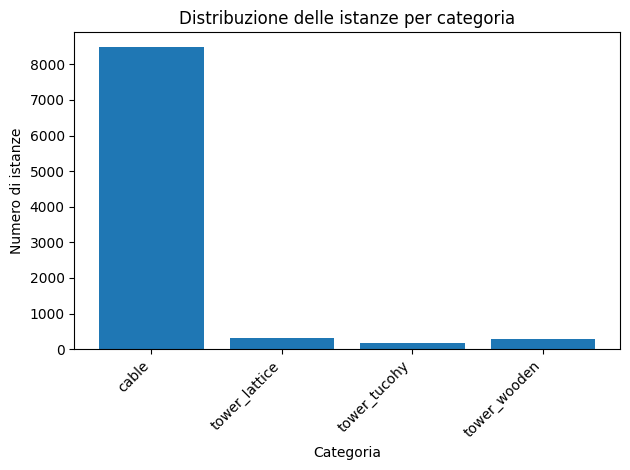

In [26]:
train_dir = "CreazioneImmagini/Dataset/trainingset"
train_json_path = os.path.join(train_dir, "train.json")
coco_train = COCO(train_json_path)

# Visualizzazione del conteggio delle istanze per categoria
category_instance_counts = {category['id']: 0 for category in categories}

for annotation_id in coco_train.getAnnIds():
    annotation = coco_train.loadAnns(annotation_id)[0]
    category_id = annotation['category_id']
    category_instance_counts[category_id] += 1

print("Conteggio delle istanze per categoria:\n")
for category_id, count in category_instance_counts.items():
    print(f"Categoria {category_id}: {count} istanze")

# Estrai le informazioni per il grafico
category_names = [category['name'] for category in categories]
category_counts = list(category_instance_counts.values())

plt.bar(category_names, category_counts)
plt.xlabel('Categoria')
plt.ylabel('Numero di istanze')
plt.title('Distribuzione delle istanze per categoria')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

### **3. Prepazione dei dati e Validazione del modello**

Utilizzando la comprensione delle liste, assegnamo ad ogni chiave del dizionario il nome del file e il percorso completo del file come valore.

Successivamente, vengono creati due elenchi (train_keys e test_keys) contenenti le chiavi dei rispettivi dizionari.



In [28]:
img_file_paths = get_img_files(train_dir)
pd.DataFrame({"Image File": [file.name for file in img_file_paths]}).head()
img_dict = {file.stem : file for file in img_file_paths}
img_test_dict = {file.stem : file for file in img_file_test_paths}

train_keys = list(img_dict.keys())
test_keys = list(img_test_dict.keys())

# Print il numero totale di campioni per ciascun insieme
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(test_keys)
}).to_frame().style.hide(axis='columns')


Training Samples:,1182
Validation Samples:,400


Visualizziamo le chiavi e gli ID delle immagini per i dataset di addestramento e test:

In [29]:
# DataFrame di addestramento
df_keys=pd.DataFrame(columns=['image_key', 'image_id'])
image_ids = coco_train.getImgIds()

for image_id in image_ids:
    image_info = coco_train.loadImgs(image_id)[0]

    image_key = image_info['file_name'].split('.')[0]
    image_id = image_info['id']

    df_keys = pd.concat([df_keys, pd.DataFrame({'image_key': [image_key], 'image_id': [image_id]})], ignore_index=True)

df_keys.head()

,image_key,image_id
0,57_01156,0
1,27_00394,1
2,59_00461,2
3,34_2295,3
4,58_00921,4


In [30]:
# DataFrame di test
df_test_keys=pd.DataFrame(columns=['image_key', 'image_id'])
image_test_ids = coco_test.getImgIds()

for image_id in image_test_ids:
    # Load image information using the COCO API
    image_info = coco_test.loadImgs(image_id)[0]

    # Extract relevant information
    image_key = image_info['file_name'].split('.')[0]
    image_id = image_info['id']

    # Append to DataFrame
    df_test_keys = pd.concat([df_test_keys, pd.DataFrame({'image_key': [image_key], 'image_id': [image_id]})], ignore_index=True)

df_test_keys.head()

,image_key,image_id
0,41_00301,0
1,76_4530,1
2,46_01086,2
3,40_00401,3
4,22_00005,4


### **4. Inizializzazione e Analisi del Modello Mask R-CNN**

In [36]:
# Inizializzazione del modello Mask R-CNN con backbone ResNet-50 FPN e pesi di default
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Ottenimento delle caratteristiche in ingresso per il box predictor e il mask predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Ottenimento del numero di canali di output per il Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

print("Caratteristiche in ingresso per il Box Predictor:", in_features_box)
print("Caratteristiche in ingresso per il Mask Predictor:", in_features_mask)
print("Numero di canali di output per il Mask Predictor:", dim_reduced)

Caratteristiche in ingresso per il Box Predictor: 1024
Caratteristiche in ingresso per il Mask Predictor: 256
Numero di canali di output per il Mask Predictor: 256


In [26]:
# Si impostano box predictor e mask predictor che inizialmente sono fissati a None
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(category_names))
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(category_names))

model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

# Riepilogo dettagliato dei parametri del modello, suddivisi per layer
summary_df = markdown_to_pandas(f"{get_module_summary(model)}")
summary_df = summary_df[summary_df.index==0 ]
summary_df

,Type,# Parameters,# Trainable Parameters,Size (bytes)
0,MaskRCNN,45.9 M,45.7 M,183 M


Si crea una nuova classe denominata ProjectDataset nella quale viene costruito il custom dataset da utilizzare per addestramento e validazione del modello. Le etichette in formato coco vengono manipolate per ottenere l'input nel formato adatto alla rete


In [32]:
class ProjectDataset(Dataset):

    def __init__(self,img_id,img_dict,cocofile,df_keys,trasforms=None):

        super(Dataset, self).__init__()

        self._img_keys = img_id  # List of image keys
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._transforms = transforms  # Image transforms to be applied
        self._cocofile=cocofile # Puntatore al json coco per prelevare informazioni
        self._df_keys=df_keys # Dizionario che mappa le chiavi ed il loro id

    def __len__(self):
            return len(self._img_keys) # Numero di elementi nel dataset

    def __getitem__(self, index):

        img_key = self._img_keys[index]

        id = self._df_keys[self._df_keys['image_key'] == img_key]['image_id'].tolist()[0]
        image, target = self._load_image_and_target(img_key,self._cocofile,id)

        return image, target

    # Conversione delle immagini e target nel formato adatto per la rete
    def _load_image_and_target(self,img_key,cocofile,id):

        filepath = self._img_dict.get(img_key)
        image = Image.open(filepath).convert('RGB')

        imageSize=image.size[::-1]

        convert_tensor = transforms.ToTensor()
        image=convert_tensor(image)

        #Si convertono le segmentazioni in maschere
        ann_ids = cocofile.getAnnIds(imgIds=id)
        annotations = cocofile.loadAnns(ann_ids)

        masks=[]
        labels=[]
        bboxes=[]
        for ann in annotations:
            # Si generano i nuovi bb nel formato richiesto
            bbox_info = ann['bbox']
            bbox = [
                bbox_info[0],
                bbox_info[1],
                bbox_info[0] + bbox_info[2],
                bbox_info[1] + bbox_info[3]
            ]
            # Se i bbox rispettano le condizioni, si aggiungono gli elementi alla lista
            if bbox[0] < bbox[2] and bbox[1] < bbox[3]:
                masks.append(torch.tensor(cocofile.annToMask(ann),dtype=torch.bool).unsqueeze(0))
                bboxes.append(bbox)
                labels.append(ann['category_id']+1)

        masks =Mask(torch.cat(masks, dim=0))
        bboxes = BoundingBoxes(data=torch.tensor(bboxes), format='xyxy', canvas_size=imageSize)
        # Si memorizza in un tensore (int) gli indici delle categorie delle annotation
        labels = torch.Tensor(labels).to(torch.int64)

        return image, {'masks': masks,'boxes': bboxes, 'labels': labels, 'id':id}



In [33]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ProjectDataset(img_id=train_keys,img_dict=img_dict,cocofile=coco_train,df_keys=df_keys,trasforms=transform)
test_dataset = ProjectDataset(img_id=test_keys,img_dict=img_test_dict,cocofile=coco_test,df_keys=df_test_keys,trasforms=transform)

pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(test_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,1182
Validation dataset size:,400


### **5. Ricerca degli Iperparametri**

La scelta dell'iperparametro learning rate (**lr**) è stata guidata dalla strategia di ricerca denominata "Grid Search", una metodologia essenziale per esplorare manualmente un insieme di iperparametri predefiniti al fine di individuare la combinazione ottimale che massimizza le prestazioni del modello Mask R-CNN.

Per la gestione del learning rate, si è adottato un set di dati di addestramento e validazione ridotti, l'ottimizzatore AdamW insieme a un learning rate scheduler dinamico, ReduceLROnPlateau. Quest'ultimo adatta il learning rate sulla base delle prestazioni del modello, riducendo il tasso di apprendimento quando la metrica di validazione cessa di migliorare.

Il numero di epoche per ogni esperimento è stato fissato a 10, con l'obiettivo principale di osservare la dinamica della perdita durante le prime epoche piuttosto che raggiungere la convergenza del modello; mentre la batch size è fissa ad 8.

Il risultato finale ha consistito nella selezione del miglior learning rate, identificato tramite la dinamica della perdita di validazione: **lr = 5e-4**.









In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Riduzione del set di dati di addestramento
reduced_train_size = 100 # Imposta il numero desiderato di campioni di addestramento
reduced_train_keys = train_keys[:reduced_train_size]

# Riduzione del set di dati di validazione
reduced_val_size = 20
reduced_val_keys = test_keys[:reduced_val_size]

reduced_train_dataset = ProjectDataset(img_id=reduced_train_keys, img_dict=img_dict, cocofile=coco_train, df_keys=df_keys, trasforms=transform)
reduced_val_dataset = ProjectDataset(img_id=reduced_val_keys, img_dict=img_test_dict, cocofile=coco_test, df_keys=df_test_keys, trasforms=transform)

# Imposta la batch size
bs = 8
reduced_train_dataloader = DataLoader(reduced_train_dataset, batch_size=bs, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=True, pin_memory_device=device)
reduced_val_dataloader = DataLoader(reduced_val_dataset, batch_size=1, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=True, pin_memory_device=device)

num_epochs_per_experiment = 10

# Spazio degli iperparametri da esplorare
param_space = {
    'lr': [5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1,1e-5, 5e-6]
    # Altri parametri
}

results = []
val_losses_list = []

# GRID SEARCH
for lr in param_space['lr']:
    config = {
        'lr': lr,
    }

    print(f'Testing Configuration: {config}')

    # Imposta l'ottimizzatore e il learning rate scheduler con il valore corrente di learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Esegui l'addestramento per un numero limitato di epoche
    for epoch in range(num_epochs_per_experiment):

        # Addestra il modello
        for batch in reduced_train_dataloader:
            inputs, labels = batch
            inputs = torch.stack(inputs).to(device)

            optimizer.zero_grad()
            losses = model(inputs.to(device), move_data_to_device(labels, device))
            loss = sum([loss for loss in losses.values()])
            loss.backward()
            optimizer.step()
            lr_scheduler.step(loss.item())

    # Valuta il modello sulla validazione
    val_loss = 0.
    for val_batch in reduced_val_dataloader:
        val_inputs, val_labels = val_batch
        val_inputs = torch.stack(val_inputs).to(device)
        val_losses = model(val_inputs.to(device), move_data_to_device(val_labels, device))
        val_loss += sum([loss for loss in val_losses.values()]).item()

    val_loss /= len(reduced_val_dataloader)
    val_losses_list.append(val_loss)

    # Memorizza i risultati della configurazione attuale
    results.append({'config': config, 'val_loss': val_loss})

# Trova la migliore configurazione in base alla perdita di validazione minima
best_config = min(results, key=lambda x: x['val_loss'])

#print(f'Best Configuration: {best_config}')

plt.plot(param_space['lr'], val_losses_list, marker='o')
plt.xscale('log')  # Scala logaritmica per il learning rate
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Learning Rate (Grid Search)')
plt.show()

Best Configuration: 5e-4

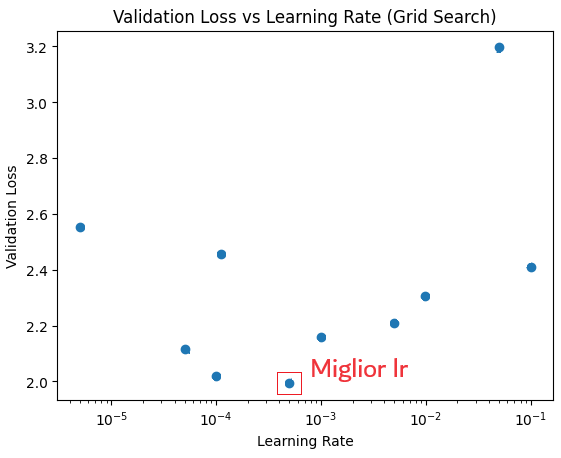

In [34]:
#Si imposta la batch size
bs = 8

# Define parameters for DataLoader
data_loader_params = {
    'collate_fn': lambda batch: tuple(zip(*batch)),
    'pin_memory': True,
    'pin_memory_device': device
}

train_dataloader = DataLoader(train_dataset,batch_size=bs, **data_loader_params, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1,**data_loader_params, shuffle=True)

pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in test DataLoader:': len(test_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,148
Number of batches in test DataLoader:,400


### **6. Addestramento e Valutazione del Modello**

Di seguito i parametri utilizzati per l'addestramento, nello specifico:

- L'ottimizzatore AdamW è utilizzato per aggiornare i pesi del modello durante l'addestramento, che include un termine di decadimento del peso per favorire la regolarizzazione e migliorare la generalizzazione del modello.

- Lo scheduler OneCycleLR è utilizzato per regolare dinamicamente il tasso di apprendimento durante l'addestramento, varia il tasso di apprendimento durante le epoche, seguendo un andamento "a un ciclo".L'obiettivo è accelerare l'addestramento nelle fasi iniziali e quindi rallentare per convergere in modo più preciso.

In [37]:
lr = 5e-4

epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,total_steps=epochs*len(train_dataloader))

#### **Addestramento del modello**

La funzione **train_one_epoch** è responsabile per l'addestramento di un singolo passaggio attraverso l'intero dataset di addestramento. Supporta l'utilizzo opzionale del parametro **scaler** per applicare la precisione mista, che consente l'uso efficiente di tipi di dati a precisione ridotta, migliorando l'efficienza computazionale. Durante ogni iterazione, viene eseguita una backward pass per calcolare i gradienti rispetto ai pesi del modello. Gli ottimizzatori, inclusi gli scalers per la precisione mista, vengono utilizzati per aggiornare i pesi del modello in base ai gradienti calcolati. Il learning rate scheduler viene aggiornato dinamicamente ad ogni iterazione per adattarsi al progresso dell'addestramento.

La funzione include anche un controllo per rilevare la presenza di valori NaN o infiniti nelle loss. Se si verifica questa situazione, l'addestramento viene interrotto per evitare problemi di convergenza. Infine, la funzione restituisce la media delle loss durante l'intera epoca, fornendo una stima della prestazione del modello durante il processo di addestramento.

In [38]:
def train_one_epoch(scaler):

    loss_history=[]
    epoch_loss = 0.
    last_loss = 0.

    progress_barTrain = tqdm(total=len(train_dataloader),desc="Train")

    for i, (inputs, labels) in enumerate(train_dataloader):

        inputs=torch.stack(inputs).to(device)

        optimizer.zero_grad()

        losses=model(inputs.to(device),move_data_to_device(labels,device))

        loss_history.append(losses.values())
        #Somma tutti i valori del vettore losses, che restituisce i valorei di loss dei vari layer
        loss = sum([loss for loss in losses.values()])

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            old_scaler = scaler.get_scale()
            scaler.update()
            new_scaler = scaler.get_scale()
            if new_scaler >= old_scaler:
                lr_scheduler.step()
        else:
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item

        progress_barTrain.update(1)

        # If the loss is NaN or infinite, stop the training/evaluation process
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at batch {i}. Stopping training")
            break

        last_loss=epoch_loss/(i+1)



    return last_loss,loss_history

#### **Valutazione del modello**

La funzione **calcolaMetriche** è stata progettata per valutare le prestazioni del modello su un set di dati di test, concentrandosi specificamente sul calcolo delle metriche **mAP** (Mean Average Precision) chemisura la capacità di un modello di object detection di riconoscere e localizzare correttamente gli oggetti nelle diverse classi e la **mAL** (Mean Average Recall) che valuta la capacità di un modello di rilevamento di oggetti o segmentazione semantica di individuare e coprire correttamente le aree degli oggetti.

Vi è una fase di preprocessing in cui le bounding boxes previste dal modello vengono arrotondate e le maschere di segmentazione vengono binarizzate utilizzando una soglia. Infine, le predizioni vengono salvate in 'pred.json'.

In [39]:
#Dizionari dei risultati
dictMetricheBBox={}
dictMetricheSegm={}
dictLoss={}


def calcolaMetriche(epoch):
    etichette=['mAP 50-95','mAP50','mAP75', 'mAP 50-95 S','mAP 50-95 M' , 'mAP 50-95 L','mAL 50-95','mAL 50','mAL 75', 'mAL 50-95 S','mAL 50-95 M' , 'mAL 50-95 L']

    results = []
    progress_barTest = tqdm(total=len(test_dataloader),desc="Evaluate")

    for image in test_dataloader:

        model.eval()
        output=model((image[0][0].unsqueeze(0)).to(device))

        classes = output[0]['labels']
        scores = output[0]['scores']
        boxes = output[0]['boxes']
        masks = output[0]['masks']

        boxes = boxes.view(-1, 4)
        masks = masks.view(-1, 700, 700)

        for i in range(masks.shape[0]):
            bbox=boxes[i]
            bbox = [bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]]
            bbox = [round(float(x)*10)/10 for x in bbox]

            masks=masks.cpu()
            maskT=masks[i].detach().numpy()
            # introduzione di una soglia per assegnare i punti non assegnati
            threshold=0.3
            maskT[maskT>threshold]=1
            maskT[maskT<=threshold]=0

            rle = pycocotools.mask.encode(np.asfortranarray(maskT.astype(np.uint8)))
            rle['counts'] = rle['counts'].decode('ascii')

            results.append({
                    'image_id': int(image[1][0]['id']),
                    'category_id': int(classes[i])-1,
                    'bbox': bbox,
                    'segmentation': rle,
                    'score': float(scores[i])
                })

        progress_barTest.update(1)

    # save file
    with open('pred.json', 'w') as fp:
        json.dump(results, fp)

    test = 'Dataset/testset/test.json'
    gt = COCO(test)
    detections = gt.loadRes('pred.json')

    #Si calcolano mAP e mAR sui bbox
    annType = 'bbox'
    cocoEval = COCOeval(gt, detections, annType)
    cocoEval.evaluate();
    cocoEval.accumulate();
    cocoEval.summarize();
    bBoxMetrics=cocoEval.stats
    bBoxDict = dict(zip(etichette, bBoxMetrics))

    #Si calcolano mAP e mAR sulla segmentazione
    annType = 'segm'
    cocoEval = COCOeval(gt, detections, annType)
    cocoEval.evaluate();
    cocoEval.accumulate();
    cocoEval.summarize();
    segmMetrics=cocoEval.stats
    segmDict = dict(zip(etichette, segmMetrics))

    dictMetricheBBox[epoch]=bBoxDict
    dictMetricheSegm[epoch]=segmDict



Infine il codice esegue l'addestramento di un modello per un numero specifico di epoche (100), utilizzando una tecnica di **gradiente scaler** se la GPU è disponibile. Ad ogni epoca, viene eseguito un passaggio attraverso i dati di addestramento e viene calcolata la loss media. Ogni 10 epoche, vengono calcolate e salvate le metriche di performance del modello sui dati di test. Viene anche registrata la loss media di addestramento per ogni epoca, e viene **salvato il modello se la loss corrente è la migliore finora**.

In [ ]:
#Counter Epoche
epoch_number = 0

epochs=150
scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None
last_loss=1_000_000.
best_metrics=-1

loss4Epoch={}

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))
    model.train(True)

    # Make sure gradient tracking is on, and do a pass over the data
    avg_loss, lossVector= train_one_epoch(scaler)
    print(f"Loss train:{avg_loss}")
    epoch_number += 1
    loss4Epoch[epoch_number]=lossVector

    calcolaMetriche(epoch_number)
    dictLoss[epoch_number]=avg_loss
    current_metrics=dictMetricheBBox[epoch_number]['mAP50'] + dictMetricheSegm[epoch_number]['mAP50']

    # Track best performance, and save the model's state
    if current_metrics>best_metrics:
        last_loss = avg_loss
        best_metrics=current_metrics
        model_path = '/content/drive/MyDrive/Progetto/model_best_epoche'
        torch.save(model.state_dict(), model_path)

    if device !='cpu':
        getattr(torch,device).empty_cache()


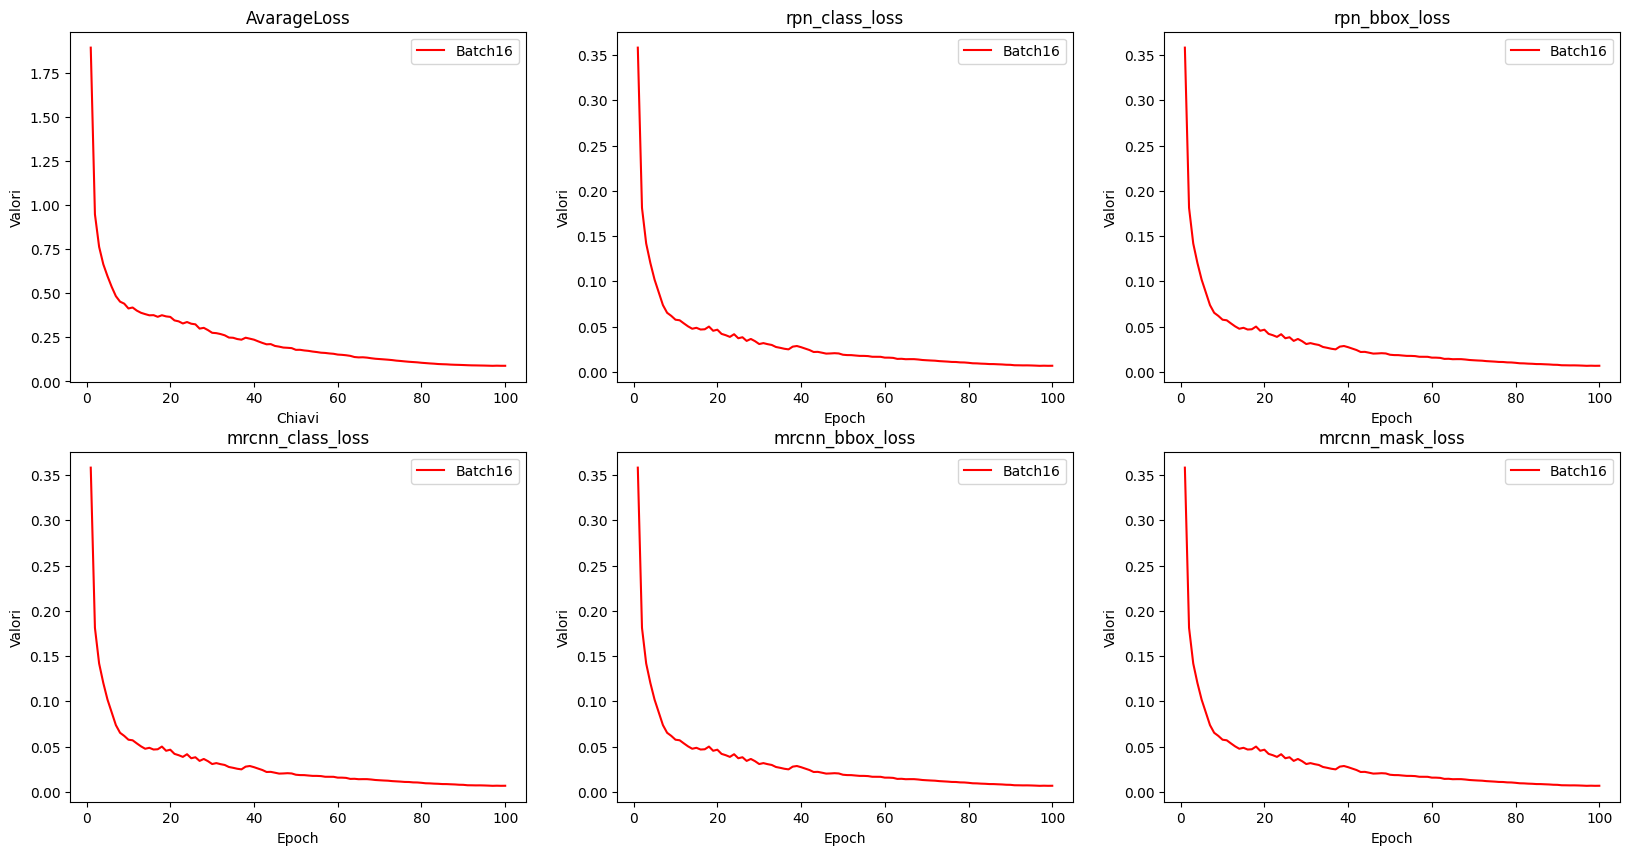

In [42]:
with open('EsecuzioneBatch16/Losses.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    loss16 = json.load(file_json)

with open('EsecuzioneBatch16/AvarageLoss.json', 'r') as file_json:
    # Carica il contenuto del file JSON
    avgLoss16 = json.load(file_json)


avg16=[]
rpn_class_loss16=[]
rpn_bbox_loss16=[]
mrcnn_class_loss16=[]
mrcnn_bbox_loss16=[]
mrcnn_mask_loss16=[]

for i in range(len(avgLoss16)+1):
    if(i>0):
        rpn_class_loss16.append(loss16[f'{i}'][0])
        rpn_bbox_loss16.append(loss16[f'{i}'][0])
        mrcnn_class_loss16.append(loss16[f'{i}'][0])
        mrcnn_bbox_loss16.append(loss16[f'{i}'][0])
        mrcnn_mask_loss16.append(loss16[f'{i}'][0])
        avg16.append(avgLoss16[f'{i}'])

epochs= list(range(1, 101))

plt.figure(figsize=(20, 10))  # Larghezza x Altezza in pollici


plt.subplot(2, 3, 1)  # 1 riga, 2 colonne, primo grafico
plt.plot(epochs, avg16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Chiavi')
plt.ylabel('Valori')
plt.title('AvarageLoss')
plt.legend()

plt.subplot(2, 3, 2)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, rpn_class_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('rpn_class_loss')
plt.legend()

plt.subplot(2, 3, 3)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, rpn_bbox_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('rpn_bbox_loss')
plt.legend()

plt.subplot(2, 3, 4)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mrcnn_class_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('mrcnn_class_loss')
plt.legend()

plt.subplot(2, 3, 5)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mrcnn_bbox_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('mrcnn_bbox_loss')
plt.legend()

plt.subplot(2, 3, 6)  # 1 riga, 2 colonne, secondo grafico
plt.plot(epochs, mrcnn_mask_loss16, linestyle='-',color='red', label='Batch16')
plt.xlabel('Epoch')
plt.ylabel('Valori')
plt.title('mrcnn_mask_loss')
plt.legend()